Visualiser les donnees

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Chargement du CSV
df = pd.read_csv("train.csv")

# Lecture d'une ligne (ex. la première)
row = df.iloc[2]

image_path = f"C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/{row['image_id']}.dicom"  # dossier contenant les images
dcm = pydicom.dcmread(image_path)
image = dcm.pixel_array

# Coordonnées de la bounding box
x_min, x_max = row['x_min'], row['x_max']
y_min, y_max = row['y_min'], row['y_max']
label = row['class_name']

fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray')  # les DICOM sont souvent en niveaux de gris
ax.set_title(label)

# Ajouter la boîte englobante
bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(bbox)

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/images/train/051132a778e61a86eb147c7c6f564dfe.dicom'

preparer les fichiers text pour l'entrainement

In [3]:
import pandas as pd
import os

# Dictionnaire des features vers ID
feature2id = {
    "Aortic enlargement": 0,
    "Atelectasis": 1,
    "Calcification": 2,
    "Cardiomegaly": 3,
    "Consolidation": 4,
    "ILD": 5,
    "Infiltration": 6,
    "Lung Opacity": 7,
    "Nodule/Mass": 8,
    "Other lesion": 9,
    "Pleural effusion": 10,
    "Pleural thickening": 11,
    "Pneumothorax": 12,
    "Pulmonary fibrosis": 13
}

# Chargement du CSV
df = pd.read_csv("train.csv")

images_path = f"C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/images"  # dossier contenant les images

# Créer un dossier pour les fichiers texte
output_dir = "C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/labels"
os.makedirs(output_dir, exist_ok=True)

# Grouper les annotations par image
for image_name, group in df.groupby('image_id'):
    
    lines = []
    for _, row in group.iterrows():
        feature = row['class_name']
        x_min, x_max = row['x_min'], row['x_max']
        y_min, y_max = row['y_min'], row['y_max']

        class_id = feature2id.get(feature)
        if class_id is None:
            continue  # ignorer les labels inconnus

        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min

        line = f"{class_id} {x_center} {y_center} {width} {height}"
        lines.append(line)

    # Écrire dans un fichier .txt
    txt_filename = os.path.splitext(image_name)[0] + ".txt"
    with open(os.path.join(output_dir, txt_filename), "w") as f:
        f.write("\n".join(lines))


Separation donnees entrainement et donnees validation

In [4]:
import os
import shutil
import random

# Dossiers d'entrée
images_dir = "C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/images"
labels_dir = "C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/labels"

# Dossiers de sortie
output_base = "C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset"
train_img_dir = os.path.join(output_base, "images/train")
val_img_dir = os.path.join(output_base, "images/val")
train_lbl_dir = os.path.join(output_base, "labels/train")
val_lbl_dir = os.path.join(output_base, "labels/val")

# Création des dossiers
for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# Liste des fichiers image
all_images = [f for f in os.listdir(images_dir)]
random.shuffle(all_images)

# Ratio de validation
val_ratio = 0.2
val_count = int(len(all_images) * val_ratio)

val_images = all_images[:val_count]
train_images = all_images[val_count:]

# Fonction de copie
def move_files(images, target_img_dir, target_lbl_dir):
    logs = []
    for img_name in images:
        base = os.path.splitext(img_name)[0]
        label_name = base + ".txt"

        src_img = os.path.join(images_dir, img_name)
        src_lbl = os.path.join(labels_dir, label_name)

        dst_img = os.path.join(target_img_dir, img_name)
        dst_lbl = os.path.join(target_lbl_dir, label_name)

        if os.path.exists(src_lbl):  # Assure que le label existe
            shutil.move(src_img, dst_img)
            shutil.move(src_lbl, dst_lbl)
        else :
            log_entry = f"not moved: {img_name}"
            print(log_entry)
            logs.append(log_entry)

# Séparer
move_files(train_images, train_img_dir, train_lbl_dir)
move_files(val_images, val_img_dir, val_lbl_dir)

print("✅ Séparation terminée !")
print(f"{len(train_images)} images pour l'entraînement")
print(f"{len(val_images)} images pour la validation")


not moved: train
not moved: val
✅ Séparation terminée !
12002 images pour l'entraînement
3000 images pour la validation


Convertir dicom->png

In [5]:
import pydicom
import numpy as np
from PIL import Image
import os

train_input_dir = "C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/images/train"

val_input_dir = "C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/images/val"

def dicom_to_png(dicom_path, png_path):
    # Read DICOM
    dcm = pydicom.dcmread(dicom_path)
    img_array = dcm.pixel_array  # This keeps the original size

    # Normalize if needed (convert to 8-bit for PNG)
    if img_array.max() > 255:
        img_array = (img_array / img_array.max() * 255).astype(np.uint8)

    # Save as PNG, same size
    img = Image.fromarray(img_array)
    img.save(png_path)

 

def convert_in_a_folder(dir):
    for filename in os.listdir(dir):
        if filename.endswith(".dicom"):
            dicom_path = os.path.join(dir, filename)
            output_name = os.path.splitext(filename)[0] + ".png"
            output_path = os.path.join(dir, output_name)

        # Read and convert
        try:
            dicom_to_png(dicom_path=dicom_path, png_path=output_path)

            # Delete original DICOM
            os.remove(dicom_path)
            print(f"✅ Converted and deleted: {filename}")

        except Exception as e:
            print(f"❌ Failed to convert {filename}: {e}")



for dir in [train_input_dir, val_input_dir]:
    convert_in_a_folder(dir)

✅ Converted and deleted: 000434271f63a053c4128a0ba6352c7f.dicom
✅ Converted and deleted: 0006e0a85696f6bb578e84fafa9a5607.dicom
✅ Converted and deleted: 0007d316f756b3fa0baea2ff514ce945.dicom
✅ Converted and deleted: 000ae00eb3942d27e0b97903dd563a6e.dicom
✅ Converted and deleted: 00150343289f317a0ad5629d5b7d9ef9.dicom
✅ Converted and deleted: 001d127bad87592efe45a5c7678f8b8d.dicom
✅ Converted and deleted: 0032c6091dc8f1b1245fc2f5f45458fa.dicom
✅ Converted and deleted: 0046f681f078851293c4e710c4466058.dicom
✅ Converted and deleted: 004d2bc2111d639f5e8441ced52d55cb.dicom
✅ Converted and deleted: 004dc2a50591fb5f1aaf012bffa95fd9.dicom
✅ Converted and deleted: 00575e3846ebd05a909d97ba59c53d30.dicom
✅ Converted and deleted: 0059d21bef1793fa9522e4ec8cae1a1a.dicom
✅ Converted and deleted: 005be26a68485912e007a3703f43d60a.dicom
✅ Converted and deleted: 0061cf6d35e253b6e7f03940592cc35e.dicom
✅ Converted and deleted: 006501b11e04aec2d403177b9ae0f34c.dicom
✅ Converted and deleted: 00675cd546313f9

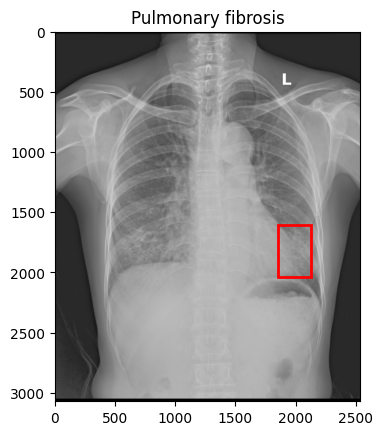

In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Chargement du CSV
df = pd.read_csv("train.csv")

# Lecture d'une ligne (ex. la première)
row = df.iloc[9]

image_path = f"C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/images/train/{row['image_id']}.png"  # dossier contenant les images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Coordonnées de la bounding box
x_min, x_max = row['x_min'], row['x_max']
y_min, y_max = row['y_min'], row['y_max']
label = row['class_name']


############################################################################

fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray')  # les DICOM sont souvent en niveaux de gris
ax.set_title(label)

# Ajouter la boîte englobante
bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(bbox)

plt.show()


In [2]:
import os
from PIL import Image


def makeLabels(images_dir, labels_dir):
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith(".txt"):
            continue
    
        # Corresponding image path
        image_file = os.path.splitext(label_file)[0] + ".png"  
        img_path = os.path.join(images_dir, image_file)
    
        # Get image size
        with Image.open(img_path) as img:
            img_w, img_h = img.size

        # Read the label file
        with open(os.path.join(labels_dir, label_file), "r") as f:
            lines = f.readlines()
    
        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
        
            cls_id = int(parts[0])
            x_center_abs = float(parts[1])
            y_center_abs = float(parts[2])
            w_abs = float(parts[3])
            h_abs = float(parts[4])

            # Normalize
            x_center = x_center_abs / img_w
            y_center = y_center_abs / img_h
            w = w_abs / img_w
            h = h_abs / img_h

            new_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")
    
        # Save in YOLO format
        with open(os.path.join(labels_dir, label_file), "w") as f:
            f.writelines(new_lines)

    print("✅ Conversion complete! YOLO labels saved in:", labels_dir)
    
    
    
train_images_dir = "C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/images/train"
val_images_dir = "C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/images/val"

train_labels_dir = "C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/labels/train"
val_labels_dir = "C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/labels/val"

makeLabels(images_dir=train_images_dir, labels_dir=train_labels_dir)
makeLabels(images_dir=val_images_dir, labels_dir=val_labels_dir)

✅ Conversion complete! YOLO labels saved in: C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/labels/train
✅ Conversion complete! YOLO labels saved in: C:/Users/moyen/Desktop/vinbigdata-chest-xray-abnormalities-detection/train/dataset/labels/val
